<a href="https://colab.research.google.com/github/PermanAtayev/Movie-revenue-prediction/blob/master/movie_revenue_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

%pip install pandas
import pandas as pd

%pip install numpy
import numpy as np

%pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib
import os

%pip install seaborn
import seaborn as sns
import ast
%pip install lightgbm
import lightgbm as lgb

%pip install xgboost
import xgboost as xgb

%pip install requests
import requests
from io import BytesIO

%pip install Pillow
from PIL import Image

%pip install eli5
import eli5


%pip install catboost
import catboost

import urllib

%pip install WordCloud
from wordcloud import WordCloud
from collections import Counter

%pip install feature_extraction
from sklearn import feature_extraction
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

%pip install keras
from keras import layers
from keras import models
from sklearn.preprocessing import LabelEncoder
from keras import regularizers
from keras.metrics import mean_squared_logarithmic_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Data

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

print(test.shape)
print(train.shape)

NameError: name 'pd' is not defined

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

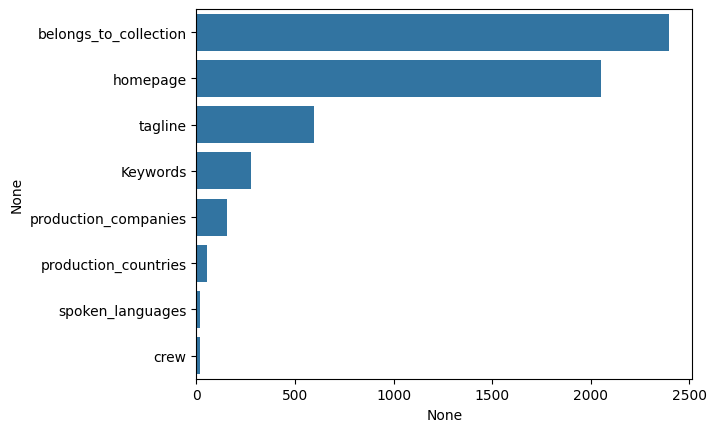

In [ ]:
missing=train.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:8],y=missing[:8].index)
plt.style.use('dark_background')
plt.show()

In [ ]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew',]

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

dfx = text_to_dict(train)
for col in dict_columns:
       train[col]=dfx[col]

In [ ]:
train['belongs_to_collection'].apply(lambda x:len(x) if x!= {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

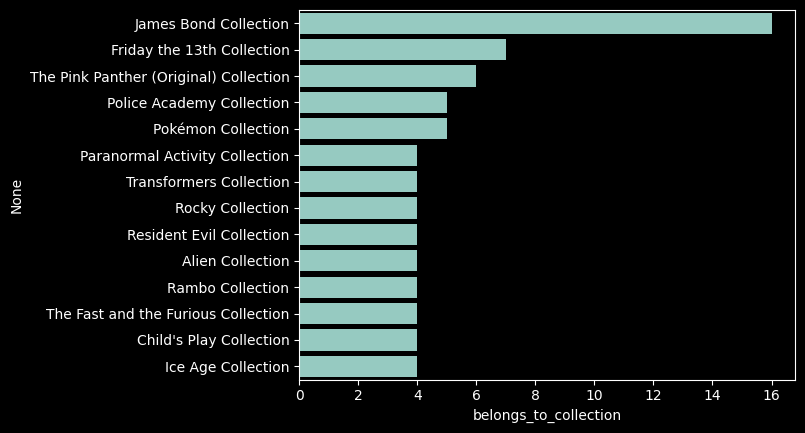

In [ ]:
collections=train['belongs_to_collection'].apply(lambda x : x[0]['name'] if x!= {} else '?').value_counts()[1:15]
sns.barplot(x=collections,y=collections.index)
plt.show()

In [ ]:
# train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
# train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

# train = train.drop(['belongs_to_collection'], axis=1)

In [ ]:
train['tagline'].apply(lambda x:1 if x is not np.nan else 0).value_counts()

1    2403
0     597
Name: tagline, dtype: int64

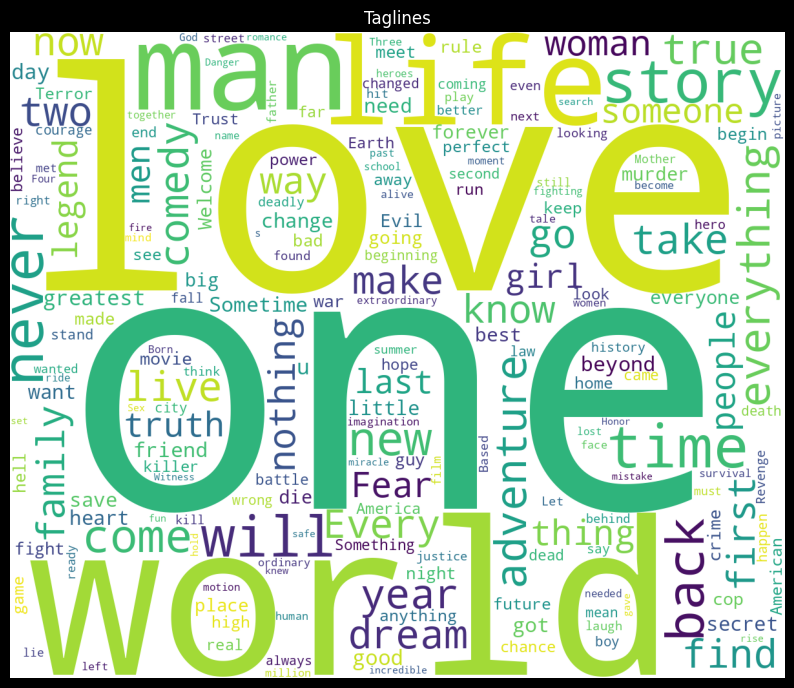

In [ ]:
plt.figure(figsize=(10,10))
taglines=' '.join(train['tagline'].apply(lambda x:x if x is not np.nan else ''))

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(taglines)
plt.imshow(wordcloud)
plt.title('Taglines')
plt.axis("off")
plt.show()

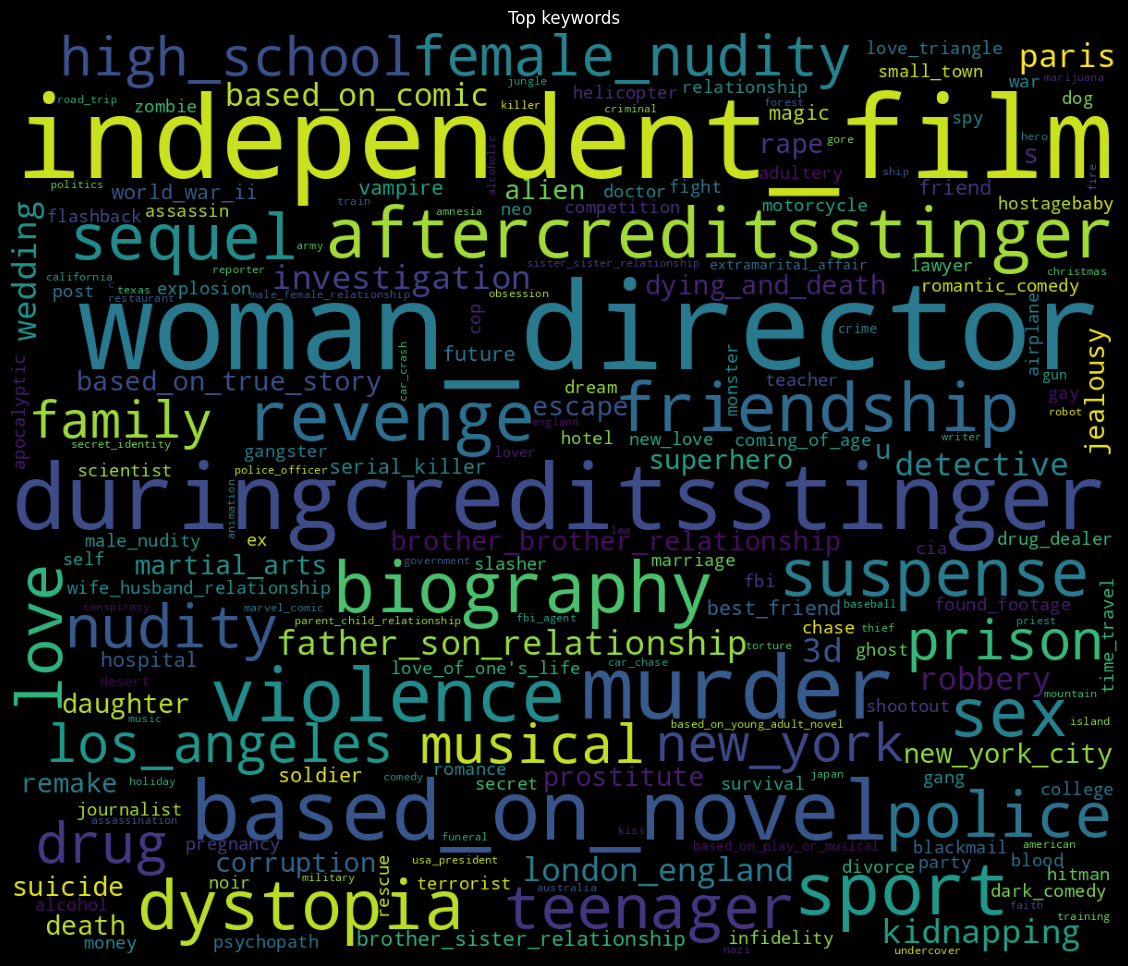

In [ ]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

<Axes: >

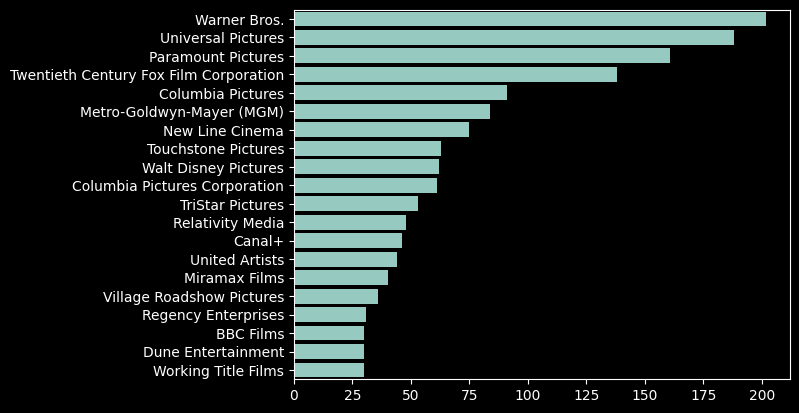

In [ ]:
x=train['production_companies'].apply(lambda x : [x[i]['name'] for i in range(len(x))] if x != {} else []).values
count=Counter([i for j in x for i in j]).most_common(20)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

<Axes: >

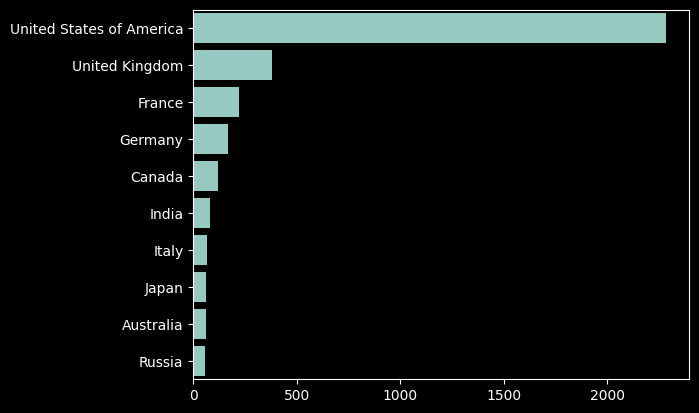

In [ ]:
countries=train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
count=Counter([j for i in countries for j in i]).most_common(10)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

In [ ]:
train['spoken_languages'].apply(lambda x:len(x) if x !={} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

<Axes: >

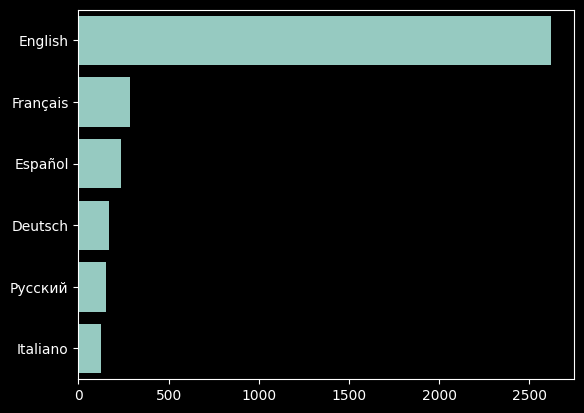

In [ ]:
lang=train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in lang for i in j]).most_common(6)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

<Axes: >

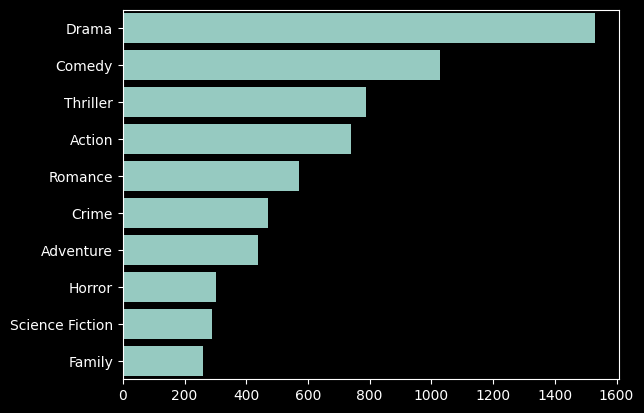

In [ ]:
genre=train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(10)
sns.barplot(x=[val[1] for val in count],y=[val[0] for val in count])

In [ ]:
dfx = text_to_dict(test)
for col in dict_columns:
  test[col]=dfx[col]

In [ ]:
train['log_revenue']=np.log1p(train['revenue'])

In [ ]:
train['revenue'].describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

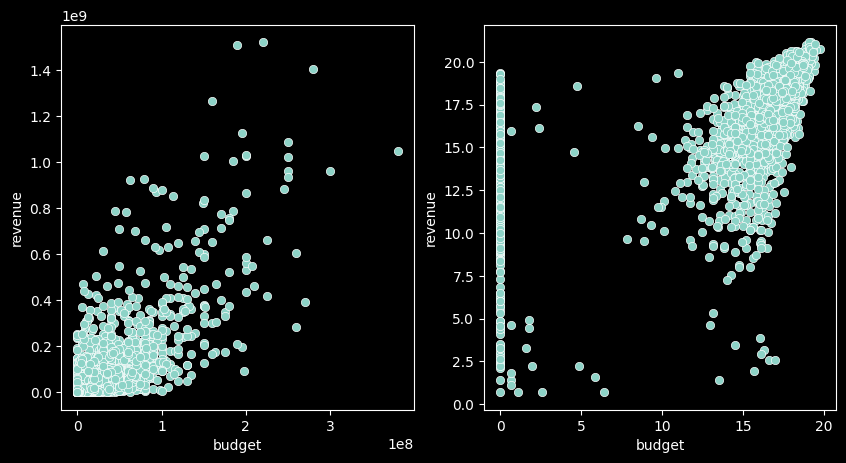

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(x=train['budget'],y=train['revenue'])
plt.subplot(1,2,2)
sns.scatterplot(x=np.log1p(train['budget']),y=np.log1p(train['revenue']))
plt.show()

In [ ]:
train['log_budget']=np.log1p(train['budget'])

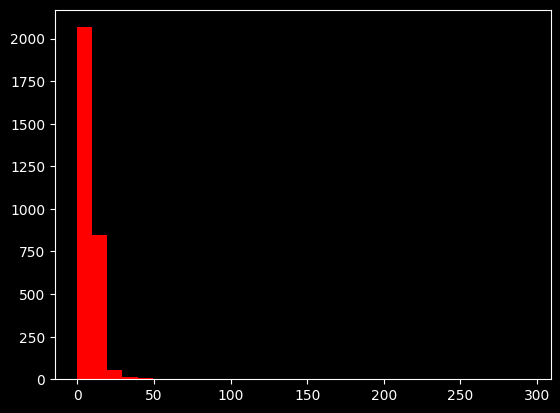

In [ ]:
plt.hist(train['popularity'],bins=30,color='red')
plt.show()

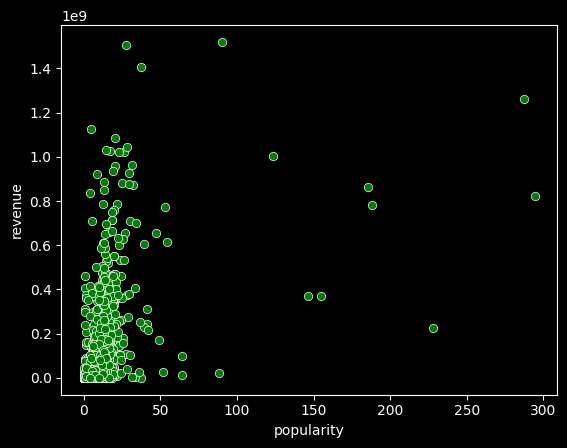

In [ ]:
sns.scatterplot(x=train['popularity'],y=train['revenue'],color='green')
plt.show()

## Splitting date, into day, month and year

In [ ]:
# Handling missing values by replacing them with '1/1/90'
train['release_date'] = train['release_date'].fillna('1/1/90')
test['release_date'] = test['release_date'].fillna('1/1/90')

# Converting to datetime objects
train['release_date'] = pd.to_datetime(train['release_date'], format='%d/%m/%y', dayfirst=True)
test['release_date'] = pd.to_datetime(test['release_date'], format='%d/%m/%y', dayfirst=True)

# Extracting day, month, and year components
train['release_day'] = train['release_date'].dt.dayofweek + 1  # Adding 1 to match lubridate's wday function
train['release_month'] = train['release_date'].dt.month
train['release_year'] = train['release_date'].dt.year
test['release_day'] = test['release_date'].dt.dayofweek + 1  # Adding 1 to match lubridate's wday function
test['release_month'] = test['release_date'].dt.month
test['release_year'] = test['release_date'].dt.year

day=train['release_day'].value_counts().sort_index()
sns.barplot(day.index,day)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='45')
plt.ylabel('No of releases')

<ipython-input-23-ab660046fb58>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=45)


Text(0, 0.5, 'No of releases')

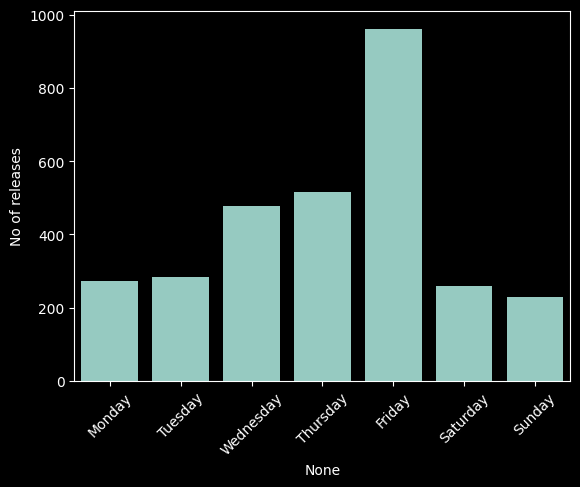

In [ ]:
import dateutil.parser

# Handling missing values by replacing them with '1/1/90'
train['release_date'] = train['release_date'].fillna('1/1/90')
test['release_date'] = test['release_date'].fillna('1/1/90')

train['release_date'] = train['release_date'].astype(str)
test['release_date'] = test['release_date'].astype(str)

# Converting to datetime objects using dateutil.parser
train['release_date'] = train['release_date'].apply(lambda x: dateutil.parser.parse(x, dayfirst=True))
test['release_date'] = test['release_date'].apply(lambda x: dateutil.parser.parse(x, dayfirst=True))

# Extracting day, month, and year components
train['release_day'] = train['release_date'].dt.weekday + 1  # Adding 1 to match lubridate's wday function
train['release_month'] = train['release_date'].dt.month
train['release_year'] = train['release_date'].dt.year
test['release_day'] = test['release_date'].dt.weekday + 1  # Adding 1 to match lubridate's wday function
test['release_month'] = test['release_date'].dt.month
test['release_year'] = test['release_date'].dt.year

# Plotting the number of releases per day of the week
day = train['release_day'].value_counts().sort_index()
sns.barplot(x=day.index, y=day)
plt.gca().set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=45)
plt.ylabel('No of releases')

<ipython-input-24-3948b35fe8d8>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)


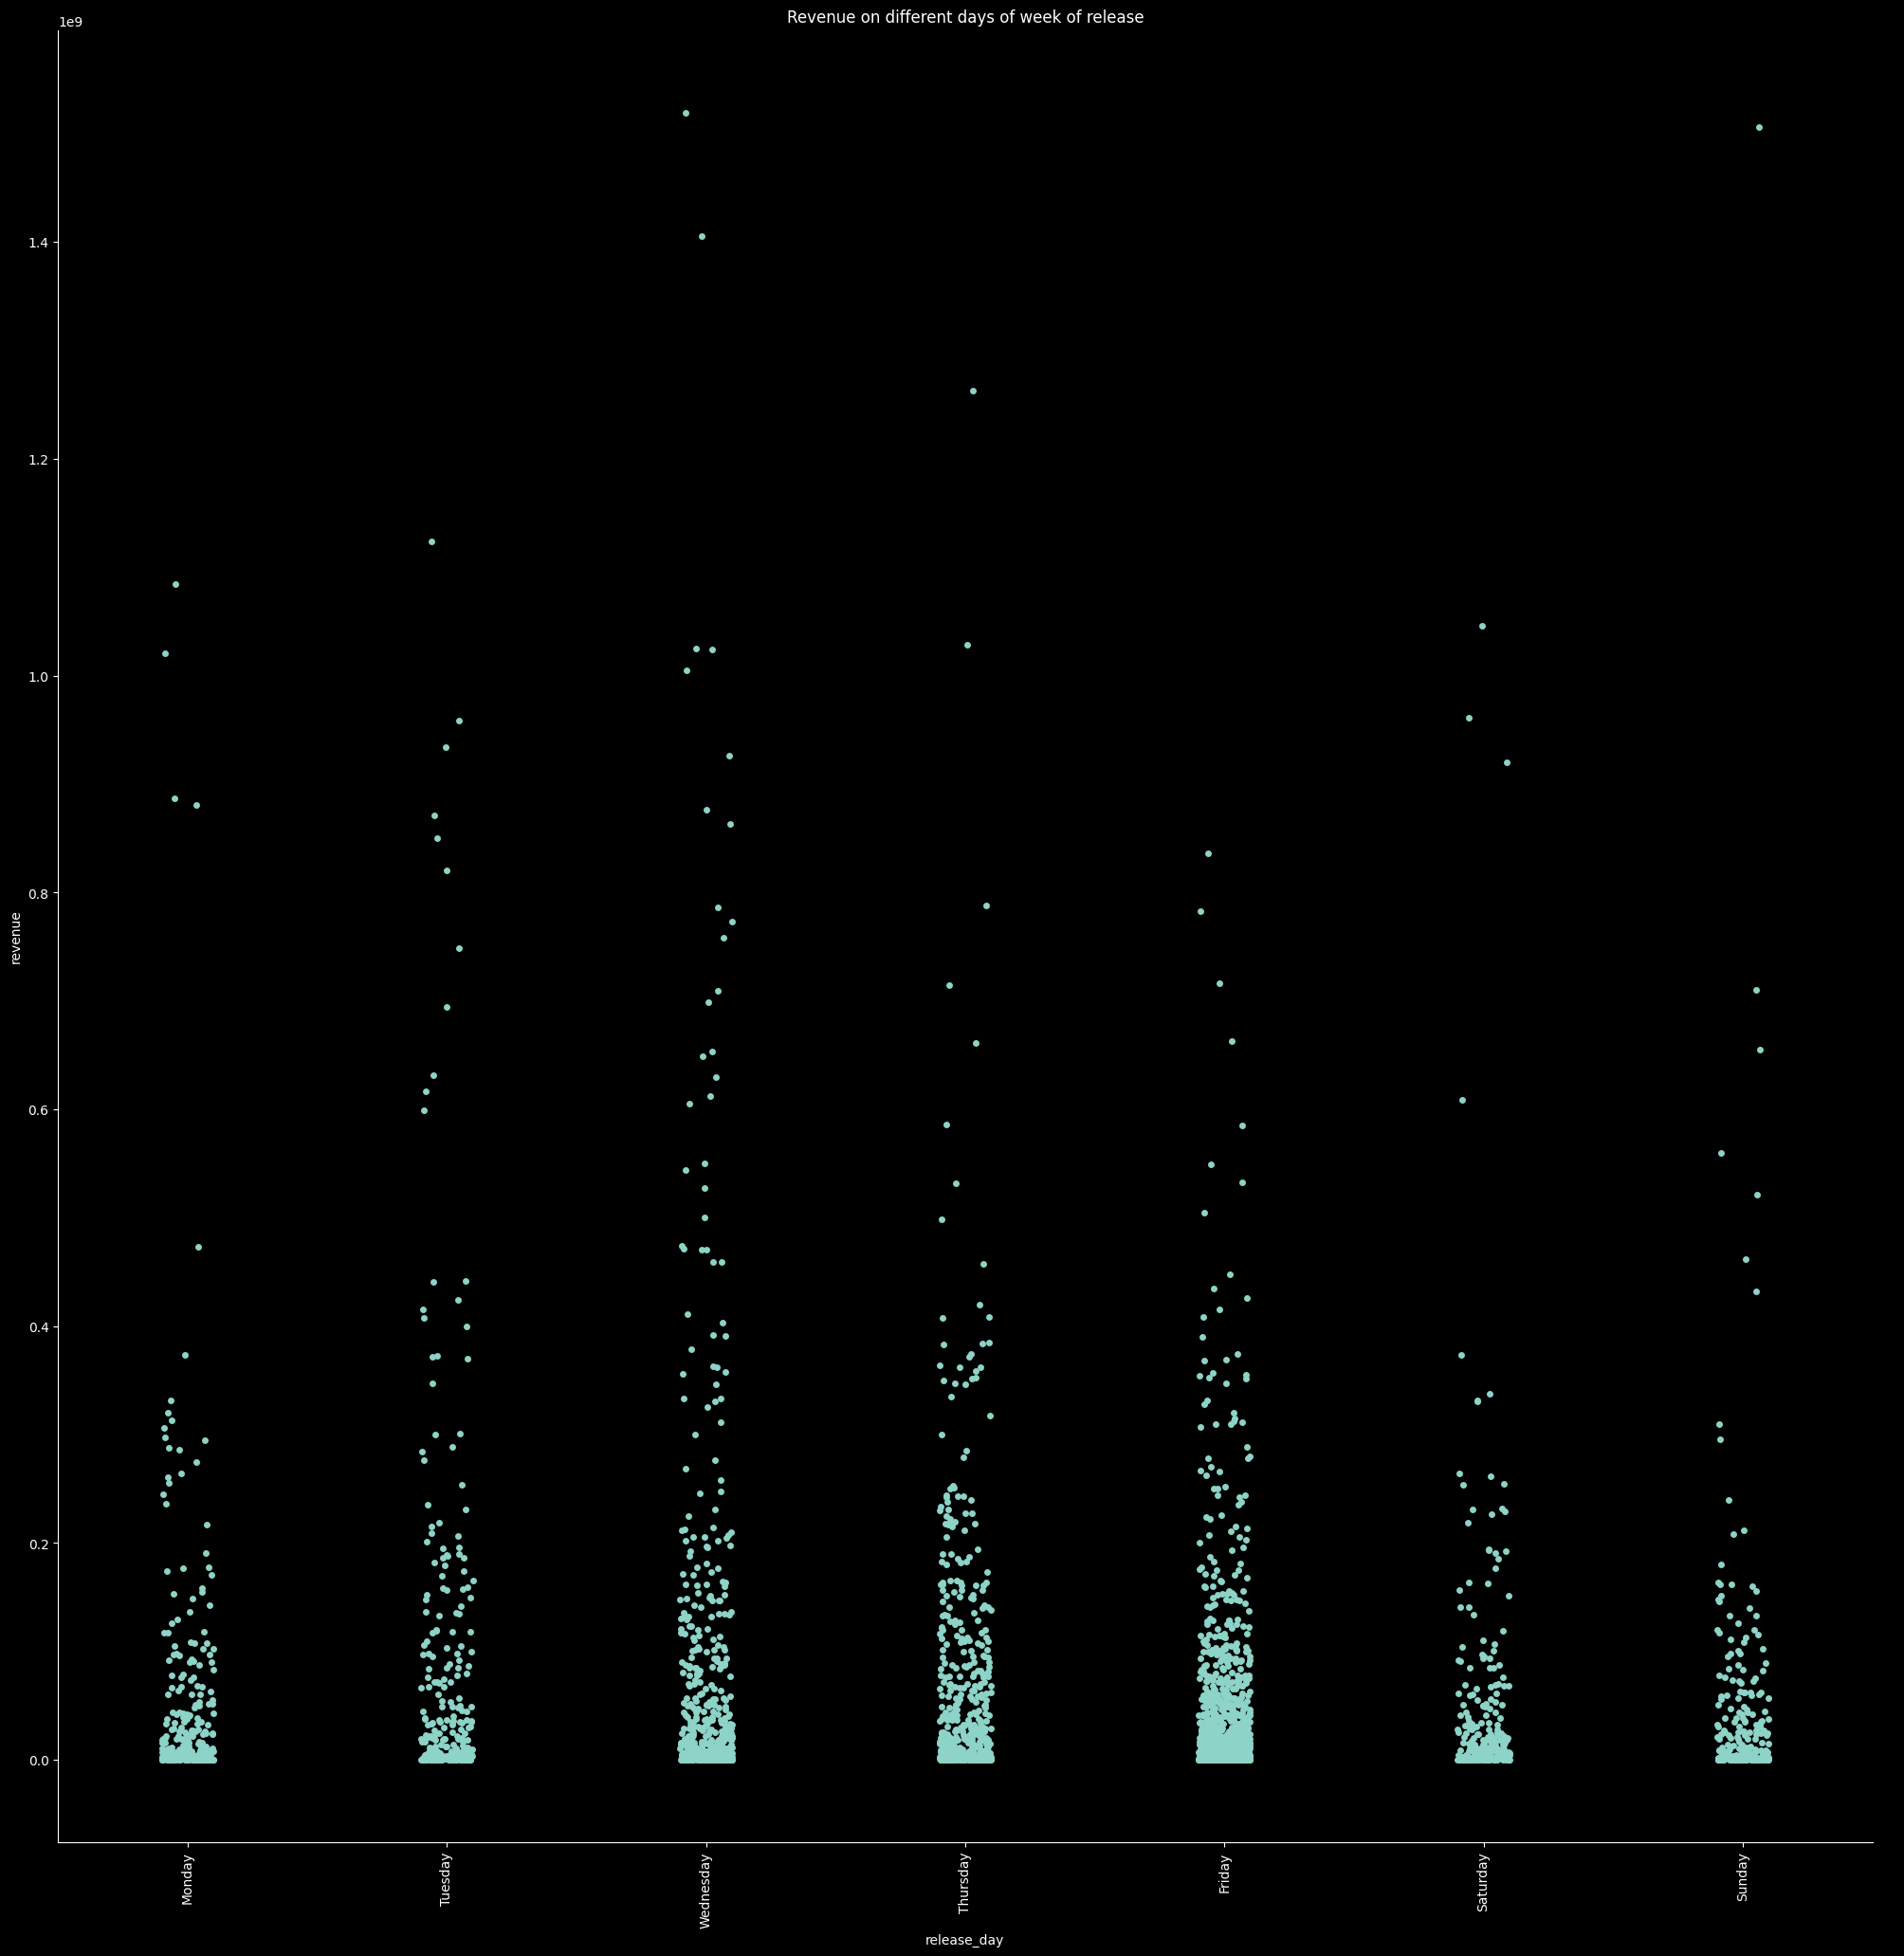

In [ ]:
sns.catplot(x='release_day',y='revenue',data=train, height=20, aspect=1)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)
plt.title('Revenue on different days of week of release');
plt.show()

<ipython-input-25-88d66c80fd64>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)


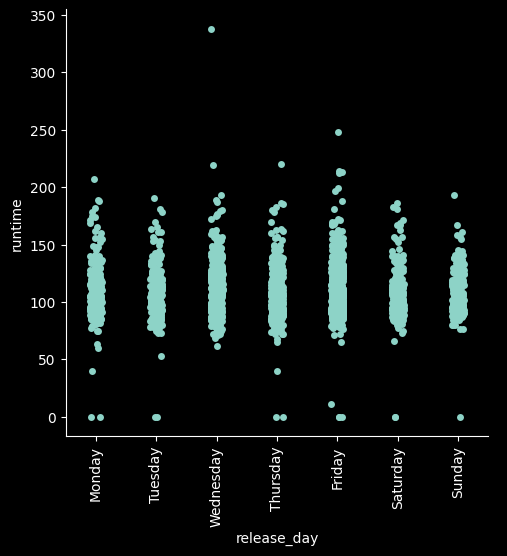

In [ ]:
sns.catplot(x='release_day',y='runtime',data=train)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation=90)
plt.show()

<ipython-input-26-86a3aad0998a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(month_lst,rotation=90)


<Figure size 1000x1500 with 0 Axes>

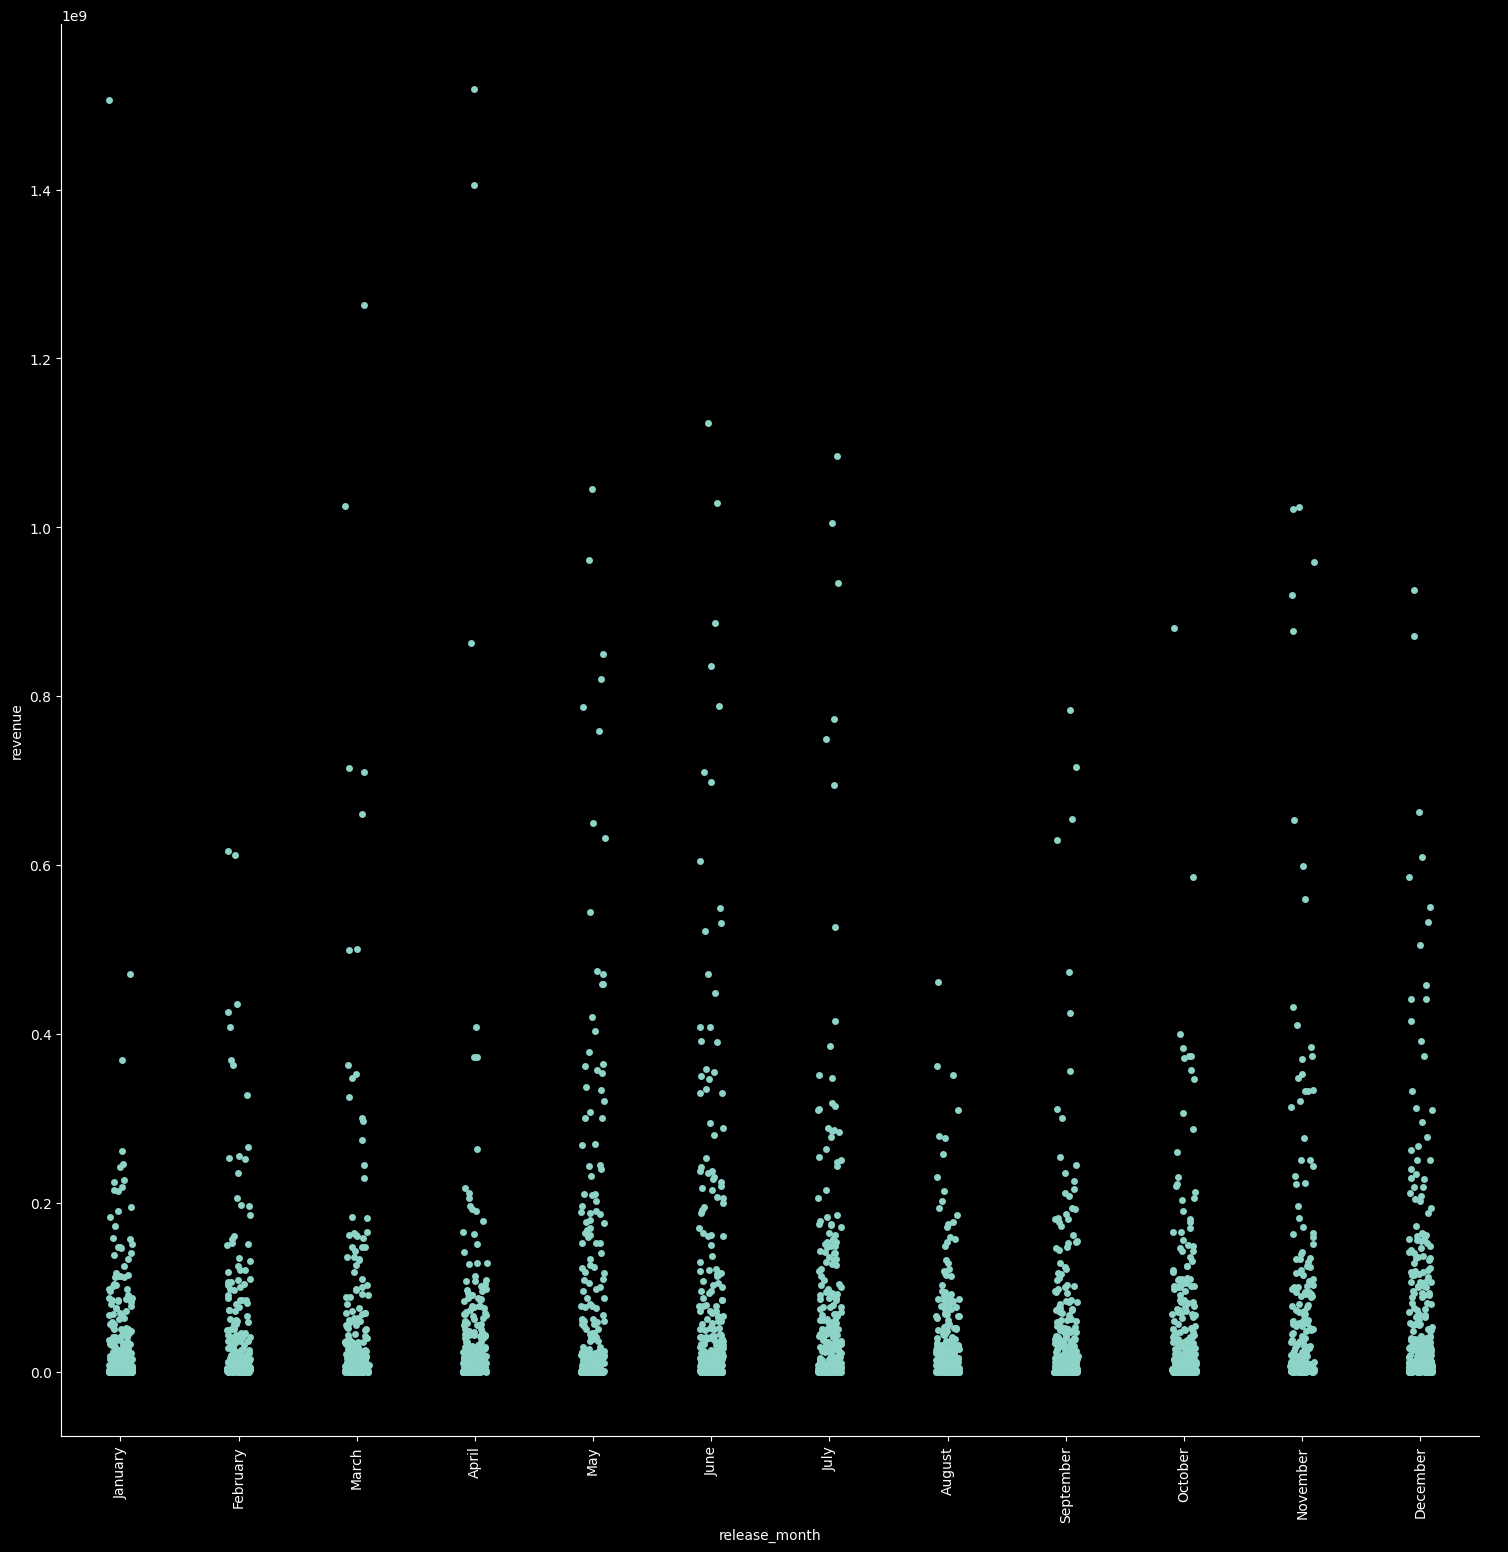

In [ ]:
plt.figure(figsize=(10,15))
sns.catplot(x='release_month',y='revenue',data=train, height=15, aspect=1)
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
plt.gca().set_xticklabels(month_lst,rotation=90)
plt.show()

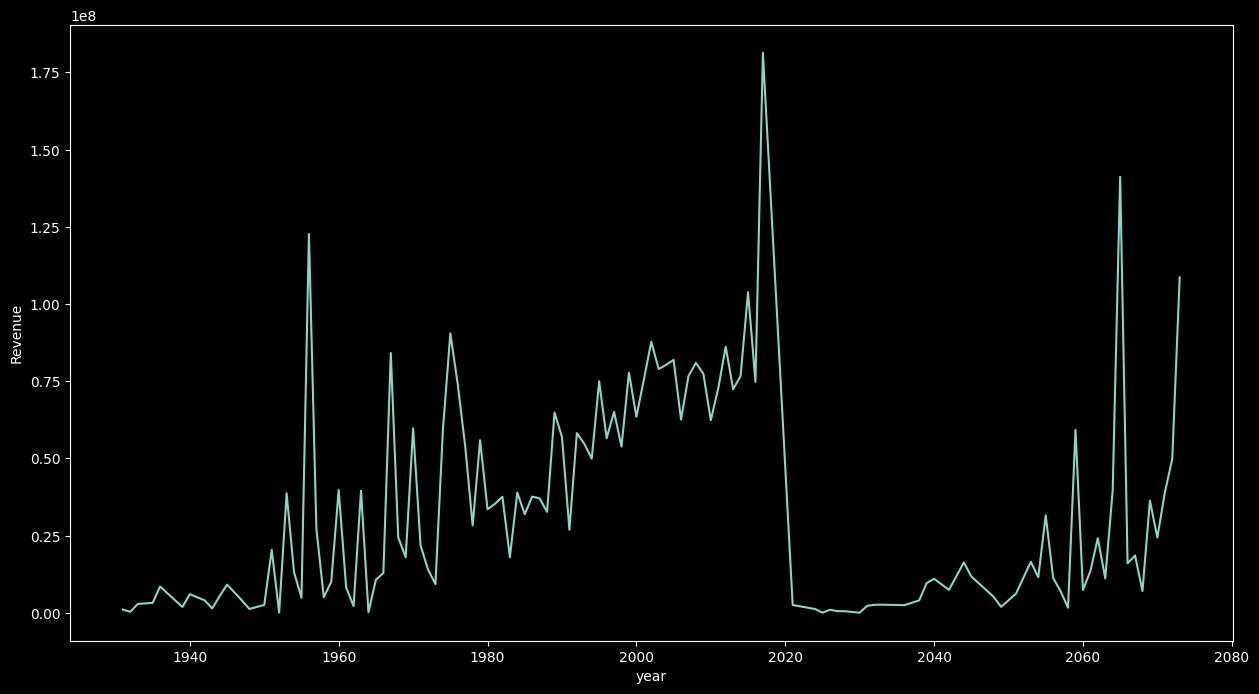

In [ ]:
plt.figure(figsize=(15,8))
yearly=train.groupby(train['release_year'])['revenue'].agg('mean')
plt.plot(yearly.index,yearly)
plt.xlabel('year')
plt.ylabel("Revenue")
plt.savefig('fig')

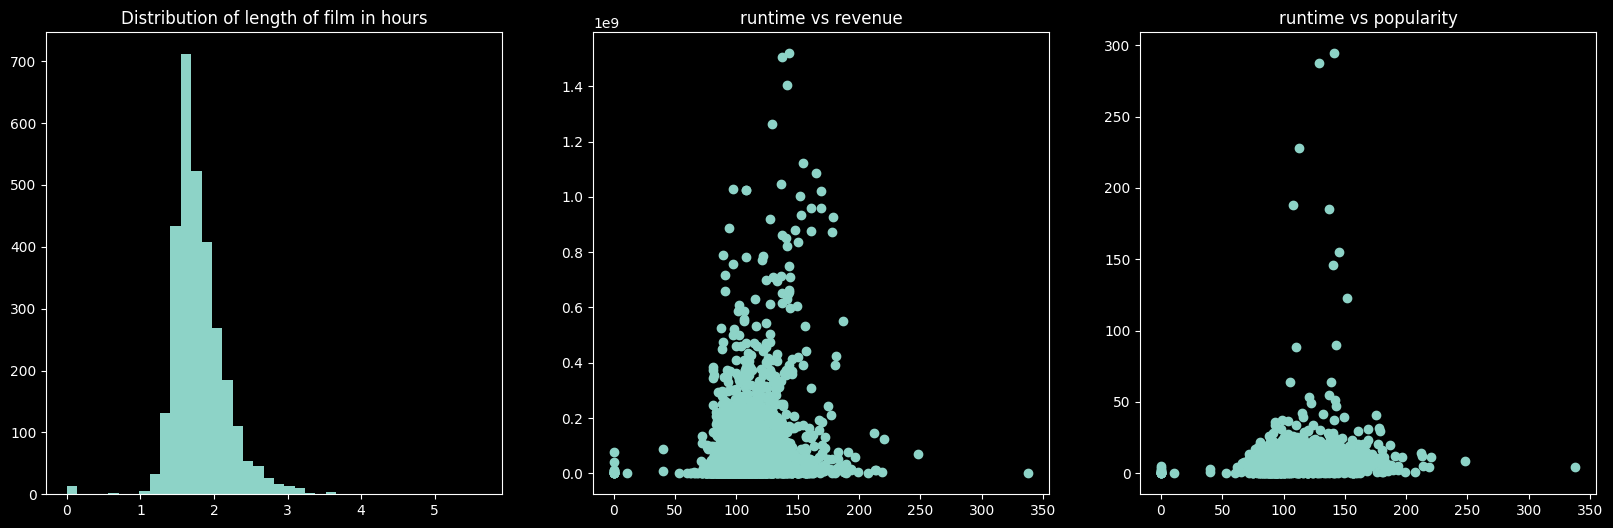

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(x=train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(x=train['runtime'].fillna(0), y=train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(x=train['runtime'].fillna(0), y=train['popularity'])
plt.title('runtime vs popularity');

In [ ]:
train['homepage'].value_counts().sort_values(ascending=False)[:5]

http://www.transformersmovie.com/           4
http://www.lordoftherings.net/              2
http://www.thehobbit.com/                   2
http://www.popperspenguins.com/main.html    1
http://www.safethefilm.com/                 1
Name: homepage, dtype: int64

In [ ]:
genres=train.loc[train['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])

<Axes: xlabel='runtime', ylabel='genres'>

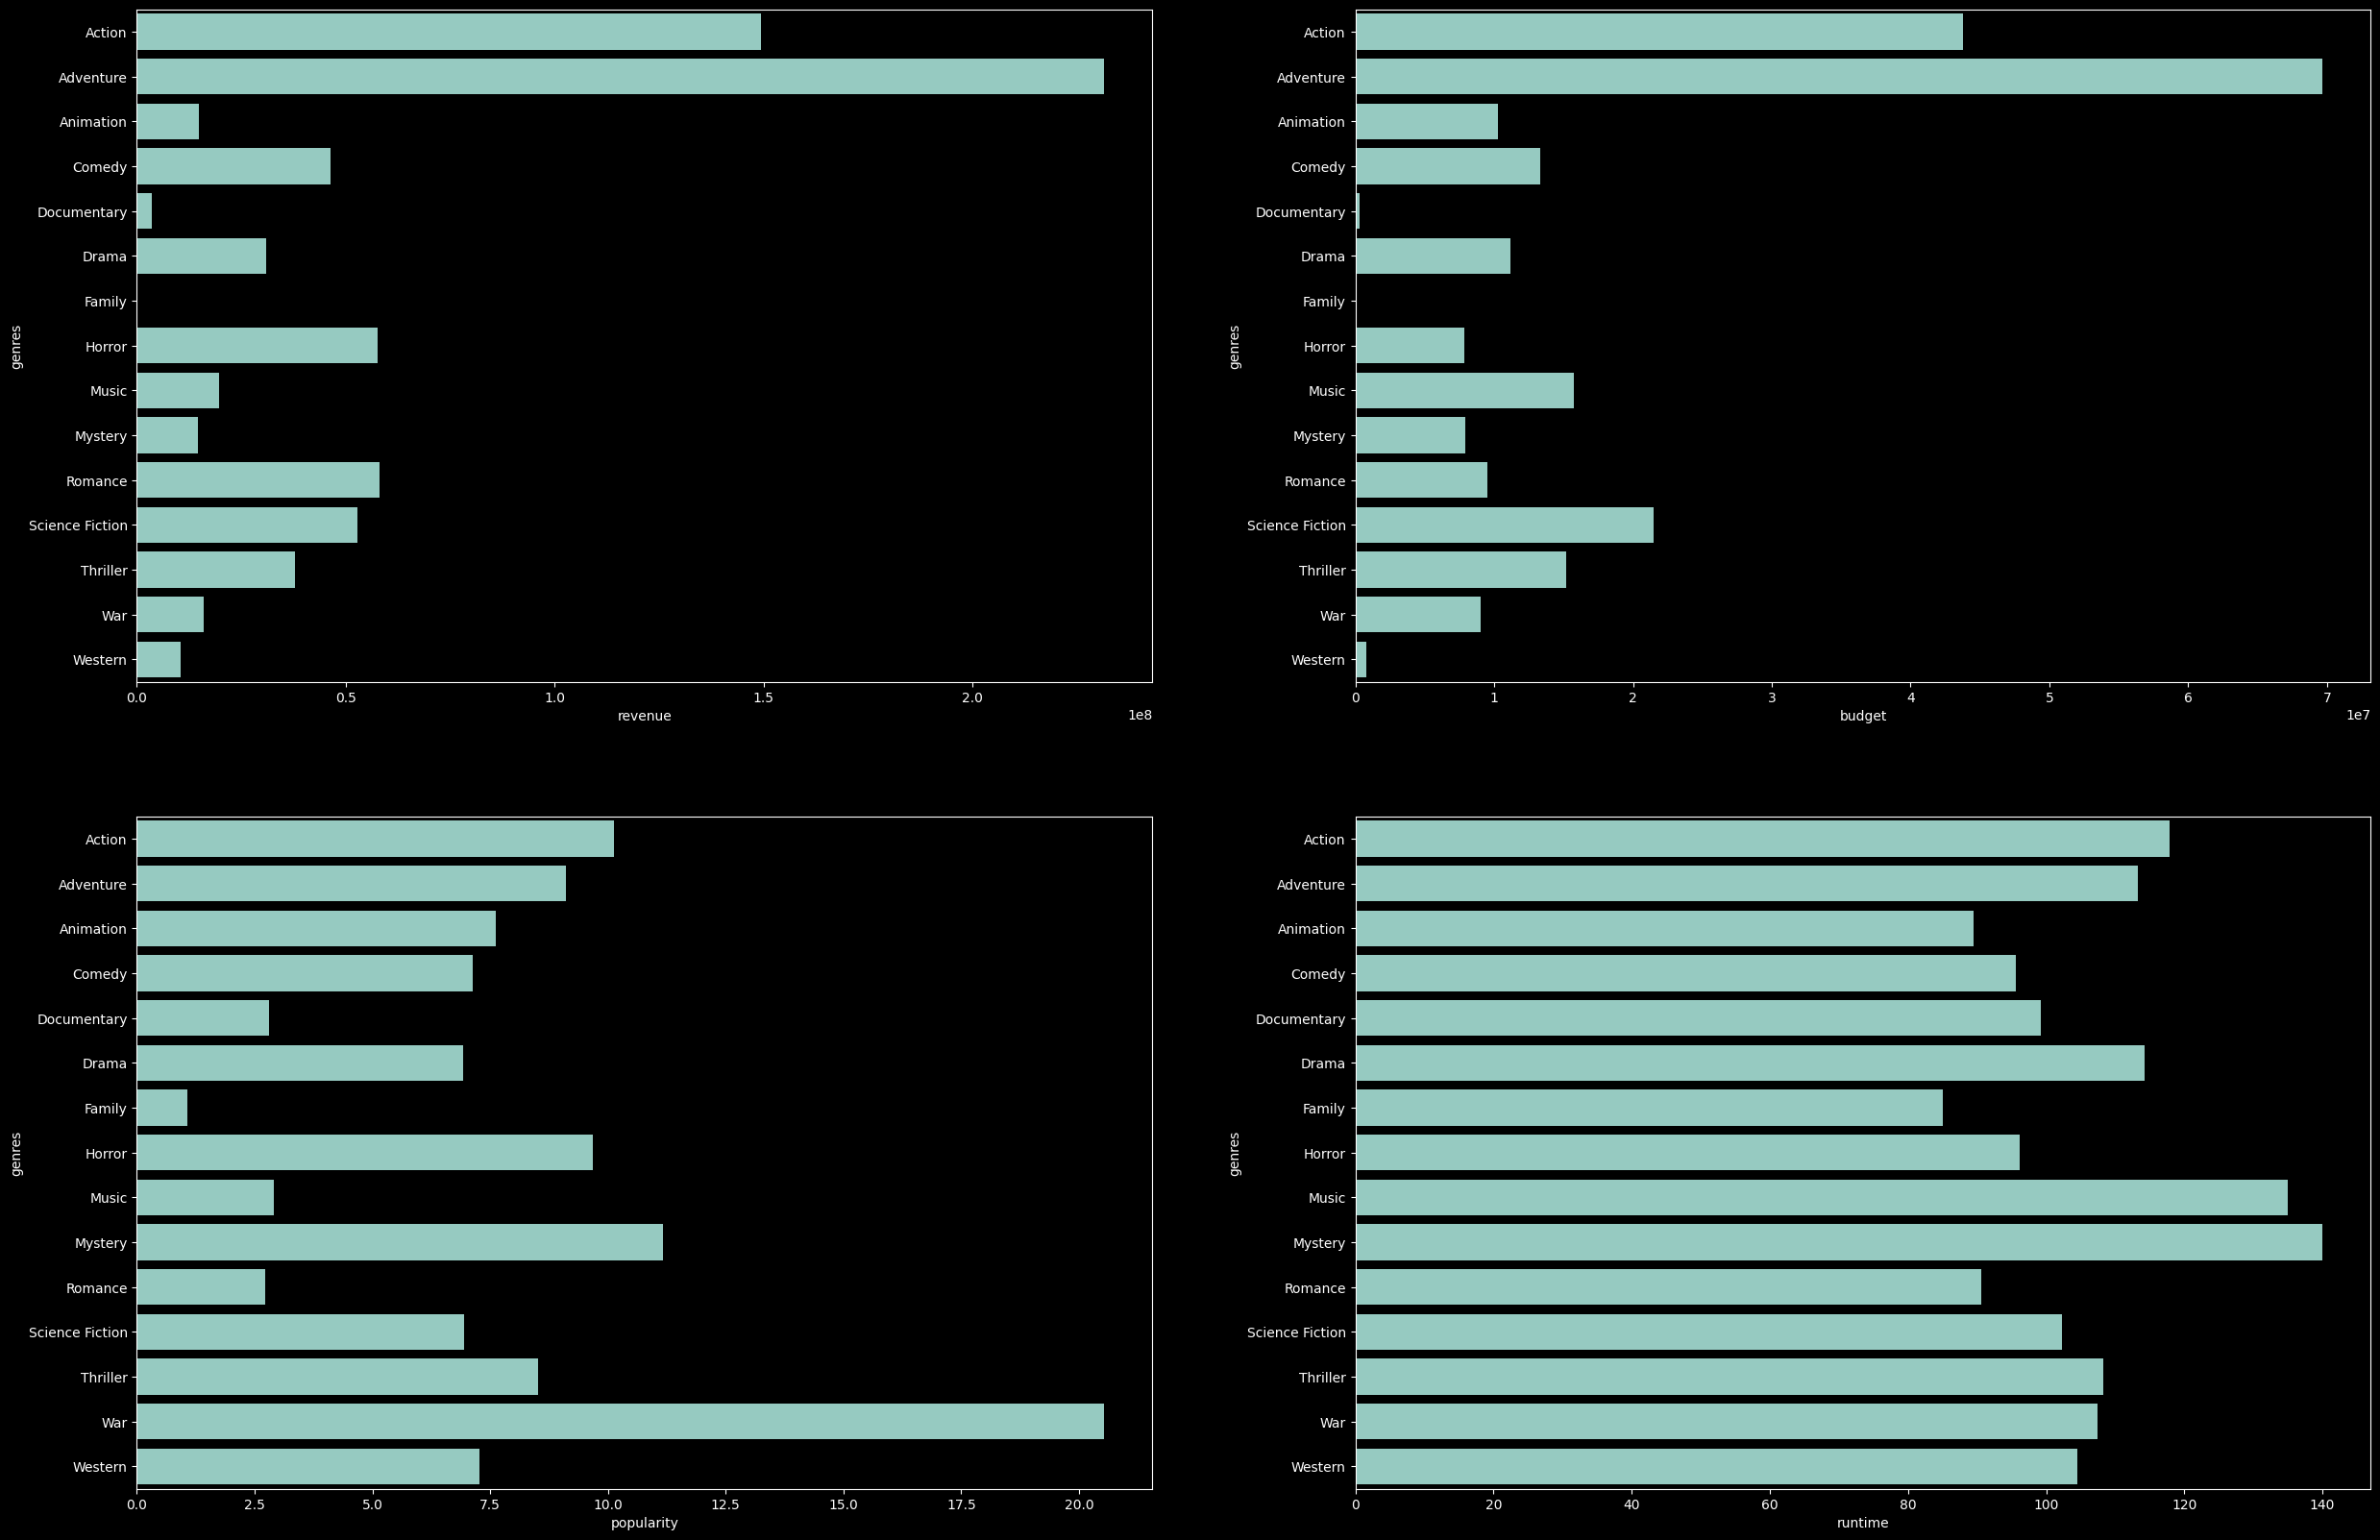

In [ ]:
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(30,20))
plt.subplot(2,2,1)
sns.barplot(x=genres['revenue'],y=genres.index)

plt.subplot(2,2,2)
sns.barplot(x=genres['budget'],y=genres.index)

plt.subplot(2,2,3)
sns.barplot(x=genres['popularity'],y=genres.index)

plt.subplot(2,2,4)
sns.barplot(x=genres['runtime'],y=genres.index)

In [ ]:
crew=train['crew'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in crew for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [ ]:
cast=train['cast'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in cast for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

In [ ]:
def prepare_data(df):
  df['_budget_runtime_ratio'] = (df['budget']/df['runtime']).replace([np.inf,-np.inf,np.nan],0)
  df['_budget_popularity_ratio'] = df['budget']/df['popularity']
  df['_budget_year_ratio'] = df['budget'].fillna(0)/(df['release_year']*df['release_year'])
  df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
  df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
  df['budget']=np.log1p(df['budget'])

  df['collection_name']=df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
  df['has_homepage']=0
  df.loc[(pd.isnull(df['homepage'])),'has_homepage']=1

  le=LabelEncoder()
  le.fit(list(df['collection_name'].fillna('')))
  df['collection_name']=le.transform(df['collection_name'].fillna('').astype(str))

  le=LabelEncoder()
  le.fit(list(df['original_language'].fillna('')))
  df['original_language']=le.transform(df['original_language'].fillna('').astype(str))

  df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
  df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)

  df['isbelongto_coll']=0
  df.loc[pd.isna(df['belongs_to_collection']),'isbelongto_coll']=1

  df['isTaglineNA'] = 0
  df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1

  df['isOriginalLanguageEng'] = 0
  df.loc[ df['original_language'].astype(str) == "en" ,"isOriginalLanguageEng"] = 1

  df['ismovie_released']=1
  df.loc[(df['status']!='Released'),'ismovie_released']=0

  df['no_spoken_languages']=df['spoken_languages'].apply(lambda x: len(x))
  df['original_title_letter_count'] = df['original_title'].str.len()
  df['original_title_word_count'] = df['original_title'].str.split().str.len()


  df['title_word_count'] = df['title'].str.split().str.len()
  df['overview_word_count'] = df['overview'].str.split().str.len()
  df['tagline_word_count'] = df['tagline'].str.split().str.len()


  df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
  df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
  df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
  df['cast_count'] = df['cast'].apply(lambda x : len(x))
  df['crew_count'] = df['crew'].apply(lambda x : len(x))

  df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
  df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
  df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

  for col in  ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
      df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
      temp = df[col].str.get_dummies(sep=',')
      df = pd.concat([df, temp], axis=1, sort=False)
  df.drop(['genres_etc'], axis = 1, inplace = True)

  cols_to_normalize=['runtime','popularity','budget','_budget_runtime_ratio','_budget_year_ratio','_budget_popularity_ratio','_releaseYear_popularity_ratio',
  '_releaseYear_popularity_ratio2','_num_Keywords','_num_cast','no_spoken_languages','original_title_letter_count','original_title_word_count',
  'title_word_count','overview_word_count','tagline_word_count','production_countries_count','production_companies_count','cast_count','crew_count',
  'genders_0_crew','genders_1_crew','genders_2_crew']
  for col in cols_to_normalize:
      print(col)
      x_array=[]
      x_array=np.array(df[col].fillna(0))
      X_norm=normalize([x_array])[0]
      df[col]=X_norm

  df = df.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','id'
  ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
  ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
  ],axis=1)

  df.fillna(value=0.0, inplace = True)

  return df


In [ ]:
def get_json(df):
    global dict_columns
    result=dict()
    for col in dict_columns:
        d=dict()
        rows=df[col].values
        for row in rows:
            if row is None: continue
            for i in row:
                if i['name'] not in d:
                    d[i['name']]=0
                else:
                    d[i['name']]+=1
            result[col]=d
    return result

In [ ]:
train_dict=get_json(train)
test_dict=get_json(test)

In [ ]:
for col in dict_columns :
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))

    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
test['revenue']=np.nan

In [ ]:
all_data=prepare_data((pd.concat([train,test]))).reset_index(drop=True)
print(train.shape)

In [ ]:
train=all_data.loc[:train.shape[0]-1,:]
test=all_data.loc[train.shape[0]:,:]
print(train.shape)

In [ ]:
train.drop('revenue',axis=1,inplace=True)
all_data.head()

In [ ]:
y=train['log_revenue']
X=train.drop(['log_revenue'],axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)
kfold=KFold(n_splits=3,random_state=42,shuffle=True)

In [ ]:
print(X.columns)
print(y)

Index(['budget', 'popularity', 'runtime', 'log_budget', 'release_day',
       'release_month', 'release_year', '_budget_runtime_ratio',
       '_budget_popularity_ratio', '_budget_year_ratio',
       ...
       'Twentieth Century Fox Film Corporation', 'UK Film Council',
       'United Artists', 'Universal Pictures', 'Village Roadshow Pictures',
       'Walt Disney Pictures', 'Warner Bros.', 'Wild Bunch',
       'Working Title Films', 'production_companies_etc'],
      dtype='object', length=171)
0       16.326300
1       18.370959
2       16.387512
3       16.588099
4       15.182615
          ...    
2995    14.283442
2996    12.103990
2997    18.309266
2998    18.962792
2999    18.223292
Name: log_revenue, Length: 3000, dtype: float64


# All metrics used to measure success of an algorithm

In [ ]:
def show_metrics(y_test, y_pred):
  print("Mean Squared Log Error = " + str(metrics.mean_squared_log_error(y_test, y_pred)))
  print("Root Mean Squared Log Error = " + str(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred))))
  print("Mean Squared Error = " + str(metrics.mean_squared_error(y_test, y_pred)))
  print("Root Mean Squared Error = " + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
  print("R^2 = " + str(metrics.r2_score(y_test, y_pred)))

# Artificial neural network

In [ ]:
%pip install tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

model=models.Sequential()
model.add(layers.Dense(356,activation='relu', kernel_regularizer=regularizers.l1(.001), input_shape=(X.shape[1],)))
model.add(layers.Dense(356,activation='relu', kernel_regularizer=regularizers.l1(.001), input_shape=(X.shape[1],)))
model.add(layers.Dense(256,kernel_regularizer=regularizers.l1(.001),activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=optimizers.RMSprop(),loss='mse',metrics=['mean_squared_logarithmic_error'])

epochs=100
hist=model.fit(X_train,y_train,epochs=epochs,verbose=0)
test_pred = model.predict(X_test)

show_metrics(y_test, test_pred)

# Light Gradient Boosting Machine

In [ ]:
def msle(y_true, y_pred):
    return 'MSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

model_lgb = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

model_lgb.fit(X_train, y_train)


prediction_lgb_test=model_lgb.predict(X_test)

show_metrics(y_test, prediction_lgb_test)

# Random Forest

In [ ]:
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_rf_base_pred = rf_base.predict(X_test)
print("Base Random Forest Regressor:\n")
show_metrics(y_test, y_rf_base_pred)


n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print("\nTuned Random Forest Regressor:\n")
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 75, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)




In [ ]:
y_rf_pred = rf_random.predict(X_test)
show_metrics(y_test, y_rf_pred)
print("\nWith the following parameters:")
print(rf_random.best_params_)

# XGBoost

In [ ]:
def xgb_model(X_train, y_train, X_test, y_test) :
  params = {'objective': 'reg:linear',
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.6,
    'colsample_bytree': 0.7,
    'eval_metric': 'rmse',
    'seed': 2020,
    'silent': True,
  }

  record = dict()

  train_data = xgb.DMatrix(data=X_train, label=y_train)

  model = xgb.train(dtrain=train_data, num_boost_round=20000, params=params)

  test_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)

  show_metrics(y_test, test_pred)

xgb_model(X_train, y_train, X_test, y_test)


In [ ]:
xgb_model(X_train, y_train, X_test, y_test)

# CatBoost Regressor

In [ ]:
from catboost import CatBoostRegressor

def cat_model(X_train, y_train, X_test, y_test) :
  model = CatBoostRegressor(iterations=10000,
  learning_rate=0.004,
  depth=5,
  colsample_bylevel=0.8,
  random_seed = 2020,
  bagging_temperature = 0.2,
  metric_period = None,
  )

  model.fit(X_train, y_train,
    verbose=False)

  test_pred = model.predict(X_test)

  show_metrics(y_test, test_pred)

cat_model(X_train, y_train, X_test, y_test)

# Elastic-Net

In [ ]:
elastic_net_model = ElasticNet(random_state=42)
elastic_net_model.fit(X_train, y_train)
y_elastic_pred = elastic_net_model.predict(X_test)
show_metrics(y_test, y_elastic_pred)

In [ ]:
elastic_net_model.get_params()

In [ ]:
elastic_netCV_model = ElasticNetCV(cv=5, random_state=42)
elastic_netCV_model.fit(X_train, y_train)
y_elastic_CV_pred = elastic_netCV_model.predict(X_test)
show_metrics(y_test, y_elastic_CV_pred)

# Ridged Regression


In [ ]:
ridged_model = Ridge(random_state=42)
ridged_model.fit(X_train, y_train)
y_ridge_pred = ridged_model.predict(X_test)
show_metrics(y_test, y_ridge_pred)

In [ ]:
ridgeCV_model = RidgeCV(alphas=[0.0005, 0.001, 0.00125, 0.0015, 0.00175, 0.002])
ridgeCV_model.fit(X_train, y_train)
y_ridgeCV_pred = ridgeCV_model.predict(X_test)
show_metrics(y_test, y_ridgeCV_pred)
print("Optimal alpha: " + str(ridgeCV_model.alpha_))

In [ ]:
#linear kernel
kernel_ridge_model = KernelRidge(alpha=ridgeCV_model.alpha_)
kernel_ridge_model.fit(X_train, y_train)
y_kernel_ridge_pred = kernel_ridge_model.predict(X_test)
show_metrics(y_test, y_kernel_ridge_pred)

# Linear Regression

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_lm_pred = lm.predict(X_test)
show_metrics(y_test, y_lm_pred)

Mean Squared Log Error = 0.03244600118277011
Root Mean Squared Log Error = 0.18012773573986351
Mean Squared Error = 4.931546729241287
Root Mean Squared Error = 2.2207086097102624
R^2 = 0.3857302204924016


# Support Vector Regression

In [ ]:
from sklearn.svm import SVR

Cval = 100
eps= 1

SVRreg = SVR(C=Cval, epsilon=eps)
SVRreg.fit(X_train,y_train)
y_pred = SVRreg.predict(X_test)
show_metrics(y_test, y_pred)

##Hyper-parameters Fine-Tuning Approaches

#### Cross Validating Params

Note: I cross-validated kernel as well with two possible values; rbf and linear. CV with linear kernel took a long time (+4h), mainly because training with linear kernal is very time consuming. I removed it from here in case the code is re-run. But its results are logged. When all features are used, RBF Kernel is better.

In [ ]:
# Cross validation
from sklearn.model_selection import GridSearchCV
params_selection = {
    "C": np.linspace(10, 200, 10),
    "epsilon": np.linspace(.02, 6, 10),
}

clf = GridSearchCV(SVR(), params_selection, verbose=5)
res = clf.fit(X_train, y_train)
# cv_results = cross_validate(SVR(), X_train, y_train, cv=5, fit_params=params_selection, scoring='neg_mean_squared_error', return_estimator=True)

In [ ]:
res.cv_results_

#### Testing with The Best Selected Modal through Grid Search Cross Validation

In [ ]:
# Best Model Test Results
print("Best Selected Model with params {}".format(res.best_params_))
best_model = res.best_estimator_
y_pred = best_model.predict(X_test)
show_metrics(y_test, y_pred)

#### Top 20 Correlated Features

##### Selecting Top 20 Correlated Features

In [ ]:
# Select top 20 featues and train and test on that
cor = train.corr(method ='pearson')
cor_target = abs(cor["log_revenue"])
relevant_features = cor_target[cor_target>0.19]
features_names = [f for f in relevant_features.index.values if f != 'log_revenue']
print(features_names)
print(len(features_names))

minimized_X_train = X_train[features_names]
minimized_X_test = X_test[features_names]

##### Training with Top 20 Correlated Features using RBF Kernel

In [ ]:
# when using kernel=rbf
print("Training with Top 20 Correlated Features using RBF Kernel")
SVRreg = SVR(C=200, epsilon=1.67)
SVRreg.fit(minimized_X_train,y_train)
y_pred = SVRreg.predict(minimized_X_test)
show_metrics(y_test, y_pred)

##### Training with Top 20 Correlated Features using Linear Kernel

In [ ]:
print("Training with Top 20 Correlated Features using Linear Kernel")
SVRreg = SVR(C=Cval, epsilon=eps, kernel='linear')
SVRreg.fit(minimized_X_train,y_train)
y_pred = SVRreg.predict(minimized_X_test)
show_metrics(y_test, y_pred)

#### Applying PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)
pca.explained_variance_ratio_

##### Training with 20-component PCA Features using RBF Kernel

In [ ]:
print("Training with 20-component PCA Features using RBF Kernel")
SVRreg = SVR(C=Cval, epsilon=eps)
SVRreg.fit(pca_X_train,y_train)
y_pred = SVRreg.predict(pca_X_test)
show_metrics(y_test, y_pred)

##### Training with 20-component PCA Features using Linear Kernel

In [ ]:
print("Training with 20-component PCA Features using Linear Kernel")
SVRreg = SVR(C=Cval, epsilon=eps, kernel='linear')
SVRreg.fit(pca_X_train,y_train)
y_pred = SVRreg.predict(pca_X_test)
show_metrics(y_test, y_pred)